In [103]:
import os
%load_ext autoreload
%autoreload 2
os.chdir('/home/users/stariq/Codes/cudaq-qrc')
!jupyter nbextension enable --py widgetsnbextension

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [104]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import os
from sklearn.preprocessing import MinMaxScaler
from dynamics import *
import re
import math
from optread import *
from scipy.stats import binom
#set latex font for plots
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
# ========= utilities for fair-size baselines =================================
def set_seed(seed):
    import random, numpy as np, torch
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def pick_emb_dim(budget, n_feat, nhead=4, nlayers=2, ff_mult=4, tol=.10):
    """
    Return the largest emb_dim (multiple of nhead) whose 2-layer Transformer
    fits within `budget·(1+tol)` params.
    """
    def n_params(d):
        mha = 3*d*d*nlayers            # Q,K,V
        out = d*d   *nlayers           # W_O
        ff  = 2*d*ff_mult*d*nlayers    # W1,W2
        ln  = 2*d*nlayers              # layer norms
        bias= d*(ff_mult*2*nlayers + nlayers + 1)  # FF + attn + regressor
        pos = d*(n_feat+1)             # pos + CLS
        return mha+out+ff+ln+bias+pos
    d = max(nhead, nhead*((budget//n_feat)//nhead))
    while n_params(d) > budget*(1+tol):
        d -= nhead
        if d < nhead: raise ValueError("budget too small")
    return d


In [4]:
# # Generate regression dataset
# X, y = make_regression(n_samples=500, n_features=8, noise=0.1, random_state=402)
# scaler_X = MinMaxScaler(feature_range=(0, 1))
# X_normalized = scaler_X.fit_transform(X)
# y = y.reshape(-1, 1)  # Reshape y to a 2D array for normalization
# scaler_y = MinMaxScaler(feature_range=(0, 1))
# y_normalized = scaler_y.fit_transform(y).flatten() 

# # First, split into 60% train and 40% temp (test + val)
# X_train, X_temp, y_train, y_temp = train_test_split(
#     X_normalized, y_normalized, test_size=0.4, shuffle=True, random_state=402
# )
# # Next, split the remaining 40% equally into test (20%) and validation (20%)
# X_test, X_val, y_test, y_val = train_test_split(
#     X_temp, y_temp, test_size=0.5, shuffle=True, random_state=402
# )

In [5]:


# 1) Lorenz trajectory --------------------------------------------------------
def generate_lorenz(n_steps, dt=0.01,
                    sigma=10.0, beta=8/3, rho=28.0,
                    state0=(0., 1., 1.05)):
    x, y, z = state0
    xs, ys, zs = np.empty(n_steps), np.empty(n_steps), np.empty(n_steps)
    for i in range(n_steps):
        x_dot = sigma * (y - x)
        y_dot = x * (rho - z) - y
        z_dot = x * y - beta * z
        x += x_dot * dt
        y += y_dot * dt
        z += z_dot * dt
        xs[i], ys[i], zs[i] = x, y, z
    return xs, ys, zs

total_steps = 10_00
xs, ys, zs  = generate_lorenz(total_steps, dt=0.01)

# 2) Build supervised X, y -----------------------------------------------------
window = 2                       # look-back length
n_samples = total_steps - window
feature_size = window * 3        # 3 coordinates × window

X = np.empty((n_samples, feature_size))
y = np.empty(n_samples)

for i in range(n_samples):
    X[i] = np.hstack((xs[i:i+window],
                      ys[i:i+window],
                      zs[i:i+window]))
    y[i] = xs[i + window]        # predict next-step x

print("Raw shapes:", X.shape, y.shape)   # (9996, 12) (9996,)

# 3) Normalise to [0, 1] -------------------------------------------------------
scaler_X = MinMaxScaler()
X_norm   = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_norm   = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

X_train, X_temp, y_train, y_temp = train_test_split(
    X_norm, y_norm,
    train_size=0.6,
    shuffle=False  # preserve time order for time‐series
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    shuffle=False
)

print("Shapes:",
      "X_train", X_train.shape,
      "X_val",   X_val.shape,
      "X_test",  X_test.shape)


Raw shapes: (998, 6) (998,)
Shapes: X_train (598, 6) X_val (200, 6) X_test (200, 6)


In [6]:
# def generate_mackey_glass(N, tau=17, beta=0.2, gamma=0.1, n=10, dt=1.0, x0=1.2):
#     """
#     Discrete‐time Mackey–Glass generator:
#       x'(t) = β x(t−τ) / (1 + x(t−τ)^n) − γ x(t)
#     Euler‐integrated with step dt.
#     Returns array of length N+tau (so you have history).
#     """
#     # initialize history with x0
#     history = np.full(tau, x0, dtype=np.float64)
#     series = []
#     for _ in range(N):
#         x_tau = history[-tau]
#         x     = history[-1]
#         x_dot = beta * x_tau / (1 + x_tau**n) - gamma * x
#         x_new = x + x_dot * dt
#         history = np.append(history, x_new)
#         series.append(x_new)
#     return np.array(series)

# # 1) Generate a long MG series
# total_steps = 1000
# raw = generate_mackey_glass(total_steps, tau=17, beta=0.2, gamma=0.1, n=10, dt=1.0)

# # 2) Build supervised X,y with window size 4
# window = 4
# X = np.array([ raw[i : i+window] for i in range(len(raw) - window) ])
# y = raw[window:]

# # 3) Normalize to [0,1]
# scaler_X = MinMaxScaler(feature_range=(0,1))
# X_norm   = scaler_X.fit_transform(X)
# scaler_y = MinMaxScaler(feature_range=(0,1))
# y_norm   = scaler_y.fit_transform(y.reshape(-1,1)).flatten()

# # 4) Split 60% train / 40% temp → then 20/20
# X_train, X_temp, y_train, y_temp = train_test_split(
#     X_norm, y_norm,
#     train_size=0.6,
#     shuffle=False  # preserve time order for time‐series
# )
# X_val, X_test, y_val, y_test = train_test_split(
#     X_temp, y_temp,
#     test_size=0.5,
#     shuffle=False
# )

# print("Shapes:",
#       "X_train", X_train.shape,
#       "X_val",   X_val.shape,
#       "X_test",  X_test.shape)
# # e.g. X_train (1175,8), X_val (392,8), X_test (392,8)

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"  # Use GPUs 0, 1, 2, and 3
#from dynamics import embeddings_multi_gpu_auto as emb_mgpu

# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)


In [12]:
#gpu count
gpu_count = torch.cuda.device_count()
print("Number of GPUs available:", gpu_count)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Number of GPUs available: 2
Using device: cuda


In [13]:
# --------------------------------------------------------------------- #
# Random-Fourier baseline in “dim-tunable” form                        #
# --------------------------------------------------------------------- #
class RandomFourierLinear(nn.Module):
    """
    φ(x) = √(2/D) cos(x·W + b)  →  linear → scalar
    Fixed W,b  (buffers, NOT trainable); only final linear is trained.
    """
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.out_dim = out_dim
        # W and b are **buffers** (frozen random features)
        self.register_buffer("W", torch.randn(in_dim, out_dim) * 0.1)
        self.register_buffer("b", torch.randn(out_dim) * 2 * math.pi)
        # Only these two tensors are trainable
        self.linear = nn.Linear(out_dim, 1)         # weight + bias

    def forward(self, x):                           # x : (B, F=in_dim)
        phi = torch.cos(x @ self.W + self.b) * math.sqrt(2 / self.out_dim)
        return self.linear(phi).squeeze(-1)

# --------------------------------------------------------------------- #
# Constructor that _search_dim_multiple_ can call                       #
# --------------------------------------------------------------------- #
def make_rff(dim):     # dim = out_dim = number of random features
    return RandomFourierLinear(in_dim=X_train_t.shape[1],
                               out_dim=dim).to(device)
    
# --------------------------------------------------------------------- #
# Trainable-parameter count helper (buffers are ignored automatically)  #
# --------------------------------------------------------------------- #
def n_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [14]:
from torch.optim.lr_scheduler import CosineAnnealingLR
# ——————— Improved MGTransformer ———————
class MGTransformer(nn.Module):
    def __init__(self,
                 n_features,
                 emb_dim=64,
                 nhead=4,
                 nhid=512,
                 nlayers=4,
                 dropout=0.1):
        super().__init__()
        # 1) scalar→emb
        self.feat_proj = nn.Linear(1, emb_dim)
        # 2) [CLS] token + pos emb
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
        self.pos_emb   = nn.Parameter(torch.randn(1, n_features+1, emb_dim))
        # 3) Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=nhead,
            dim_feedforward=nhid,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, nlayers)
        # 4) final regressor
        self.regressor   = nn.Linear(emb_dim, 1)

    def forward(self, x):
        # x: (B, n_features)
        B, F = x.shape
        # 1) project each scalar
        h = self.feat_proj(x.unsqueeze(-1))       # (B, F, emb_dim)
        # 2) prepend CLS
        cls = self.cls_token.expand(B, -1, -1)    # (B, 1, emb_dim)
        h   = torch.cat([cls, h], dim=1)          # (B, F+1, emb_dim)
        # 3) add positional embeddings
        h  += self.pos_emb                         # broadcast (1, F+1, emb_dim)
        # 4) transformer
        h   = self.transformer(h)                 # (B, F+1, emb_dim)
        # 5) take CLS slot and regress
        out = h[:, 0]                             # (B, emb_dim)
        return self.regressor(out).squeeze(-1)    # (B,)

In [15]:
from tqdm.auto import tqdm
import torch.nn.functional as F

# ──────────────────────────────────────────────────────────────────────
def train(model, loader_tr, *,
          epochs      = 500,
          lr          = 1e-3,
          weight_decay= 1e-4,
          patience    = 30,
          desc        = "train",
          early_stop  = True        # ← NEW: set False to run full epochs
          ):
    """
    If early_stop=True  (default) → stop after `patience` epochs without
    improvement and restore the best weights.

    If early_stop=False → always run the full `epochs`, but still restore the
    best checkpoint at the very end.

    Returns
    -------
    losses : list[float]
        epoch-wise training MSE (length == epochs if early_stop==False,
        otherwise length == actual number of epochs executed)
    """
    opt   = torch.optim.Adam(model.parameters(), lr=lr,
                             weight_decay=weight_decay)
    best_state, best_loss, wait = None, float("inf"), 0
    losses = []

    bar = tqdm(range(1, epochs+1), desc=f"{desc}: loss=∞", leave=False)
    for ep in bar:
        model.train()
        running = 0.0

        for batch in loader_tr:                       # unpack as before
            if len(batch) == 3:
                xb, res, yb = batch;  res = res.to(device)
            else:
                xb, yb = batch;       res = None
            xb, yb = xb.to(device), yb.to(device)

            pred  = model(xb, res) if res is not None else model(xb)
            loss  = F.mse_loss(pred, yb)

            opt.zero_grad(); loss.backward(); opt.step()
            running += loss.item() * xb.size(0)

        epoch_loss = running / len(loader_tr.dataset)
        losses.append(epoch_loss)
        bar.set_description(f"{desc}: loss={epoch_loss:.4e}")

        # keep best checkpoint
        if epoch_loss < best_loss:
            best_loss, best_state = epoch_loss, model.state_dict().copy()
            wait = 0
        else:
            wait += 1

        # break if we want early stopping
        if early_stop and wait >= patience:
            break

    bar.close()
    # always restore the best model before returning
    model.load_state_dict(best_state)
    return losses
# ──────────────────────────────────────────────────────────────────────

# ──────────────────────────────────────────────────────────────────────
def predict(model, loader):
    """return torch.cat(preds), torch.cat(trues)  on *loader*"""
    model.eval(); preds, trues = [], []
    with torch.no_grad():
        for batch in loader:
            if len(batch) == 3:
                xb, res, yb = batch; res = res.to(device)
            else:
                xb, yb = batch;     res = None
            xb = xb.to(device)
            p  = model(xb, res) if res is not None else model(xb)
            preds.append(p.cpu()); trues.append(yb)
    return torch.cat(preds), torch.cat(trues)
# ──────────────────────────────────────────────────────────────────────

In [16]:
# ——————— Prepare DataLoaders ———————
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)
loader_tr = DataLoader(train_ds, batch_size=32, shuffle=True)
loader_te = DataLoader(test_ds,  batch_size=32, shuffle=False)

In [17]:
######### Vaniala simulator ##########  
# train_embeddings = simulator.apply_layer(train_datapoints_normalized)
# test_embeddings = simulator.apply_layer(test_datapoints_normalized)
# train_embeddings=train_embeddings/(2**nsites) #normalize embeddings
# #val_embeddings=val_embeddings/(2**nsites) #normalize embeddings
# test_embeddings=test_embeddings/(2**nsites) #normalize embeddings

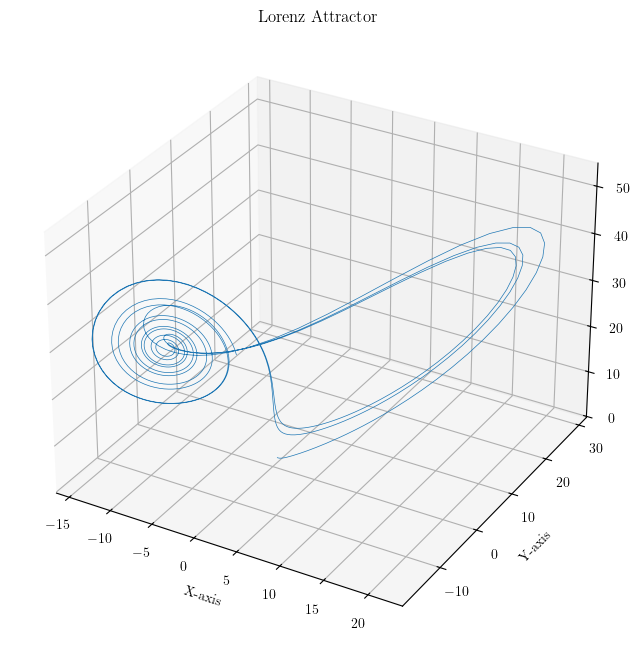

In [18]:
#plot the 3d lorenz attractor
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Lorenz Attractor')
plt.show()
    

In [19]:
all_train_emb, all_test_emb = {}, {}

for n in range(2, 11):          # 2 … 10 qubits
    tr_emb, te_emb = get_embeddings_for_nsites(
        nsites      = n,
        X_train     = X_train,     # your current arrays
        X_test      = X_test,
        dataset_tag = "Lorenz"   # or "MackeyGlass", etc.
    )
    all_train_emb[n] = tr_emb
    all_test_emb[n]  = te_emb


✓ n=2: loaded cached embeddings
✓ n=3: loaded cached embeddings
✓ n=4: loaded cached embeddings
✓ n=5: loaded cached embeddings
✓ n=6: loaded cached embeddings
✓ n=7: loaded cached embeddings
✓ n=8: loaded cached embeddings
✓ n=9: loaded cached embeddings
✓ n=10: loaded cached embeddings


In [292]:
# ##### Single-GPU #####


# train_embeddings = embeddings_with_cache(
#     simulator,
#     train_datapoints_normalized,
#     cache_dir="cache",
#     final_dir="dataset/embeddings",
#     config_name=cfg_t,
#     batch_size=10,            # optional
# )
# test_embeddings  = embeddings_with_cache(
#     simulator,
#     test_datapoints_normalized,
#     cache_dir="cache",
#     final_dir="dataset/embeddings",
#     config_name=cfg_test,
# )
# train_embeddings /= 2**nsites
# test_embeddings  /= 2**nsites


In [293]:
#testing for n = 2
nsites = 8
readouts = generate_readouts(nsites)
train_embeddings = all_train_emb[nsites]
test_embeddings = all_test_emb[nsites]
T_res = 6
R = len(readouts)
print("train_flat.shape:", train_embeddings.shape)
print("test_flat.shape: ", test_embeddings.shape)

train_flat.shape: (598, 648)
test_flat.shape:  (200, 648)


In [294]:
# # 3) reshape into 3D
# N, D = train_embeddings.shape
# N_test, D_test = test_embeddings.shape
# train3 = train_embeddings.reshape(N, T_res, R)
# test3  = test_embeddings.reshape(N_test, T_res, R)


# # inject a realistic cocktail of errors
# train_noisy3 = noisy_embeddings(train3, gaussian_sigma=0.2,
#                                 multiplicative_sigma=0.01,
#                                 shots=800,
#                                 T2=3.0, dt=0.5)
# test_noisy3  = noisy_embeddings(test3,  gaussian_sigma=0.2,
#                                 multiplicative_sigma=0.01,
#                                 shots=800,
#                                 T2=3.0, dt=0.5)


In [295]:
torch.manual_seed(0)
# reshape to (batch, T, R)
R = len(readouts)
T = train_embeddings.shape[1] // R
res_tr = train_embeddings.reshape(-1, T, R)
res_te = test_embeddings.reshape(-1, T, R)

# res_tr =selected_train_embeddings.reshape(-1, T, R)
# res_te =selected_test_embeddings.reshape(-1, T, R)
# to tensors
res_tr_t = torch.tensor(res_tr, dtype=torch.float32)
res_te_t = torch.tensor(res_te, dtype=torch.float32)
ld_qr_tr = DataLoader(
    TensorDataset(X_train_t, res_tr_t, y_train_t),
    batch_size=32, shuffle=True
)
ld_qr_te = DataLoader(
    TensorDataset(X_test_t,  res_te_t,  y_test_t),
    batch_size=32
)


In [296]:
# class ReservoirAttentionLayer(nn.Module):
#     def __init__(self, emb_dim, readouts, out_dim=None):
#         super().__init__()
#         self.value_proj = nn.Linear(emb_dim, out_dim or emb_dim)
#         self.res_proj   = nn.Linear(readouts, 1)
#         self.head       = nn.Linear(out_dim or emb_dim, 1)
#     def forward(self, emb, reservoir):
#         scores = self.res_proj(reservoir)     # (batch,T,1)
#         attn   = torch.softmax(scores, dim=1)
#         V      = self.value_proj(emb).unsqueeze(1).expand(-1, T, -1)
#         out    = (attn * V).sum(dim=1)
#         return self.head(out).squeeze(-1)

# # DataLoaders
# loader2_tr = DataLoader(TensorDataset(X_train_t, res_tr_t, y_train_t), batch_size=32, shuffle=True)
# loader2_te = DataLoader(TensorDataset(X_test_t,  res_te_t,  y_test_t ), batch_size=32)
# # Model, opt
# model2 = ReservoirAttentionLayer(emb_dim=X_train.shape[1], readouts=R, out_dim=256).to(device)
# opt2   = torch.optim.Adam(model2.parameters(), lr=1e-3)

# # train
# mses_2 = []
# epochs = 1000
# lossf = nn.MSELoss()
# for epoch in range(epochs):
#     model2.train()
#     total_loss = 0.0
#     for xb, resb, yb in loader2_tr:
#         xb, resb, yb = xb.to(device), resb.to(device), yb.to(device)
#         loss = lossf(model2(xb, resb), yb)
#         opt2.zero_grad(); loss.backward(); opt2.step()
#         total_loss += loss.item() * xb.size(0)
#     avg_loss = total_loss / len(loader2_tr.dataset)
#     mses_2.append(avg_loss)
#     if (epoch+1) % 10 == 0:
#         print(f"Epoch {epoch+1:03d}/{epochs} — Train MSE: {avg_loss:.6f}")
    
# # eval
# model2.eval(); preds2, true2 = [], []
# with torch.no_grad():
#     for xb, resb, yb in loader2_te:
#         p2 = model2(xb.to(device), resb.to(device)).cpu().numpy()
#         preds2.append(p2); true2.append(yb.numpy())
# preds2 = np.concatenate(preds2)
# true2  = np.concatenate(true2)
# mse2 = mean_squared_error(true2, preds2)
# print(f"Reservoir-Attention Model Test MSE: {mse2:.8f}")

In [297]:
# #count parameters
# print("Reservoir-Attention Model params:", count_parameters(model2))

In [298]:
class QRCrossAttnLayer(nn.Module):
    """
    Cross-attention from the reservoir onto *all* tokens.
    reservoir : (B,T,R)
    tokens    : (B,F+1,E)
    x_feat_emb: (B,E)  – mean-pooled scalar embedding
    """
    def __init__(self, emb_dim, res_dim, ff_mult=1, dropout=0.0):
        super().__init__()
        self.score_proj = nn.Linear(res_dim, 1)      # (T,R) → (T,1)
        self.ff = nn.Sequential(
            nn.Linear(emb_dim, ff_mult * emb_dim),
            nn.GELU(),
            nn.Linear(ff_mult * emb_dim, emb_dim),
        )
        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)

    def forward(self, tokens, reservoir, x_feat_emb):
        # 1) attention weights from reservoir
        attn    = torch.softmax(self.score_proj(reservoir), dim=1)   # (B,T,1)

        # 2) value vector = feature embedding (no extra proj)
        context = (attn * x_feat_emb.unsqueeze(1)).sum(1)            # (B,E)

        # 3) add to *every* token, then FFN
        tokens  = self.norm1(tokens + context.unsqueeze(1))
        tokens  = self.norm2(tokens + self.ff(tokens))
        return tokens




class MGTransformerQR(nn.Module):
    """
    Quantum-Transformer with   ① single cross-attn QR layer
                               ② MLP width = ff_mult × emb_dim
                               ③ no positional tokens (we treat the
                                  whole window as one “super-token”)
    """
    def __init__(self, n_features, res_dim, emb_dim,
                 ff_mult: int = 4, dropout: float = 0.0):
        super().__init__()

        # project the whole feature window in one shot
        self.feat_proj = nn.Linear(n_features, emb_dim)

        # one QR cross-attention layer
        self.layer = QRCrossAttnLayer(
            emb_dim, res_dim,
            ff_mult = ff_mult,
            dropout = dropout
        )

        self.regressor = nn.Linear(emb_dim, 1)

    def forward(self, x, reservoir):
        """
        x         : (B, F)         – Mackey-Glass window (F = 4)
        reservoir : (B, T, R)
        """
        feat_emb = self.feat_proj(x)        # (B, E)
        tokens   = feat_emb.unsqueeze(1)    # fake 1-token “sequence”

        tokens   = self.layer(tokens, reservoir, feat_emb)
        return self.regressor(tokens.squeeze(1)).squeeze(-1)







In [299]:
# ════════════════════════════════════════════════════════════════════
# 1️⃣  parameter counter & emb-dim search
# ════════════════════════════════════════════════════════════════════
def n_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def search_dim_multiple(
        ctor, *, target,  nhead=4,  low=8, high=512, tol=0.05, **kw):
    """
    Binary-search emb_dim (multiple of nhead) so that
    |#params - target| / target  ≤ tol
    """
    low  = math.ceil(low  / nhead) * nhead
    high = math.floor(high / nhead) * nhead
    best, best_p = None, float("inf")

    while low <= high:
        mid   = (low + high) // (2*nhead) * nhead  # rounded to multiple
        model = ctor(mid, **kw);  p = n_params(model)

        if abs(p-target) <= tol*target:   # hit!
            return model, p
        if p < target: low  = mid + nhead
        else:          high = mid - nhead

        if abs(p-target) < abs(best_p-target):
            best, best_p = model, p
    return best, best_p                        # closest found


# ════════════════════════════════════════════════════════════════════
# 2️⃣  constructors with **identical MLP width 4×E** and depth = 1
# ════════════════════════════════════════════════════════════════════
def make_transformer(E):
    return MGTransformer(
        n_features = X_train_t.shape[1],
        emb_dim    = E,
        nhead      = 4,
        nhid       = 4*E,        # << 4× hidden
        nlayers    = 1,
        dropout    = 0.0).to(device)

def make_qt(E):
    return MGTransformerQR(
        n_features = X_train_t.shape[1],
        res_dim    = R,
        emb_dim    = E,
        ff_mult    = 4,          # << 4× hidden (matches above)
        dropout    = 0.0).to(device)

def make_rff(D):                 # D = # random features
    return RandomFourierLinear(
        in_dim  = X_train_t.shape[1],
        out_dim = D).to(device)


# ════════════════════════════════════════════════════════════════════
# 3️⃣  pick dimensions so every model ≈ TARGET params
# ════════════════════════════════════════════════════════════════════
TARGET = 1_500        # you can change this in one place

model_tf , p_tf  = search_dim_multiple(make_transformer,
                                       target=TARGET, nhead=4)
model_rff, p_rff = search_dim_multiple(make_rff,
                                       target=TARGET, nhead=1,
                                       low=32, high=12_000)

print(f"Transformer         : {p_tf :>5} params  (E={model_tf.feat_proj.out_features})")

print(f"Random Fourier      : {p_rff:>5} params  (D={model_rff.out_dim})")

Transformer         :  2017 params  (E=12)
Random Fourier      :  1528 params  (D=1527)


In [300]:
loss_tf  = train(model_tf , loader_tr, desc="Transformer",early_stop=False, epochs=300)
loss_rff = train(model_rff, loader_tr, desc="RFF", early_stop=False, epochs=300)

Transformer: loss=∞:   0%|          | 0/300 [00:00<?, ?it/s]

RFF: loss=∞:   0%|          | 0/300 [00:00<?, ?it/s]

In [301]:
model_qt , p_qt  = search_dim_multiple(make_qt,
                                       target=TARGET, nhead=4)
print(f"Quantum-Transformer : {p_qt :>5} params  (E={model_qt.feat_proj.out_features})")
loss_qt  = train(model_qt , ld_qr_tr , desc="QT", early_stop=False, epochs=300)


Quantum-Transformer :  1466 params  (E=12)


QT: loss=∞:   0%|          | 0/300 [00:00<?, ?it/s]

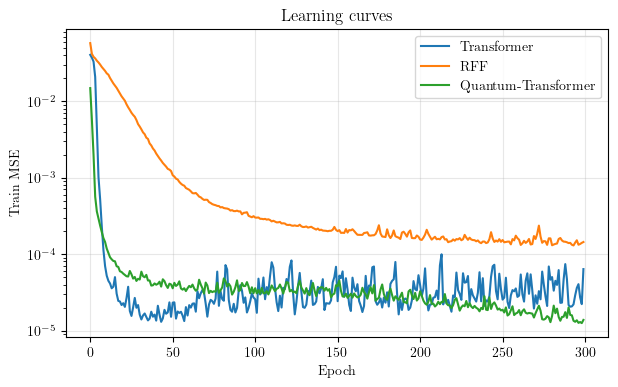

In [302]:
plt.figure(figsize=(7,4))
plt.plot(loss_tf , label="Transformer")
plt.plot(loss_rff, label="RFF")
plt.plot(loss_qt , label="Quantum-Transformer")
plt.yscale("log")
plt.xlabel("Epoch"); plt.ylabel("Train MSE"); plt.title("Learning curves")
plt.legend(); plt.grid(alpha=.3)
plt.show()


In [303]:
pred_tf , true_tf  = predict(model_tf , loader_te)
pred_rff, true_rff = predict(model_rff, loader_te)     # same targets
pred_qt , _        = predict(model_qt , ld_qr_te)


In [304]:
#1000
print("\n=====  Test MSE =====")
print(f"Transformer        : {mean_squared_error(true_tf, pred_tf):.8f}")
print(f"RFF                : {mean_squared_error(true_rff, pred_rff):.8f}")
print(f"Quantum-Transformer: {mean_squared_error(true_tf, pred_qt):.8f}")


=====  Test MSE =====
Transformer        : 0.00001310
RFF                : 0.00003934
Quantum-Transformer: 0.00003008


In [ ]:
#2: 0.00000718
#3: 0.00000245
#4: 0.00000612
#5: 0.00000342
#6: 0.00000179
#7: 0.00002893
#8: 0.00003008

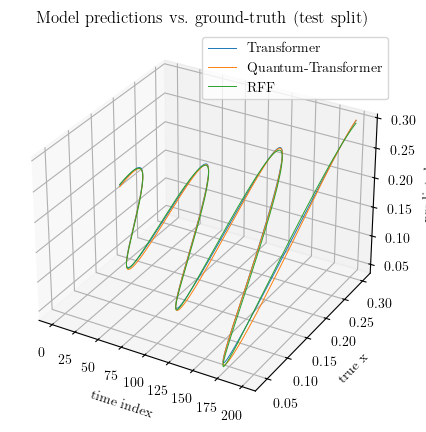

In [306]:
import numpy as np
fig = plt.figure(figsize=(7,5))
ax  = fig.add_subplot(111, projection="3d")

t = np.arange(len(pred_tf))            # test-time index

# plot as thin ribbons so they don't occlude each other
ax.plot(t, true_tf , pred_tf , lw=0.7, label="Transformer")
ax.plot(t, true_tf , pred_qt , lw=0.7, label="Quantum-Transformer")
ax.plot(t, true_tf , pred_rff, lw=0.7, label="RFF")

ax.set_xlabel("time index")
ax.set_ylabel("true  x")
ax.set_zlabel("predicted  x")
ax.set_title("Model predictions vs. ground-truth (test split)")
ax.legend();  plt.show()


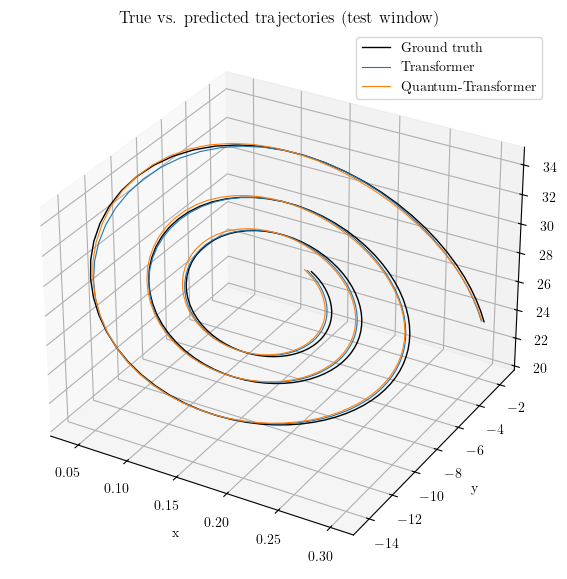

In [307]:
# restrict to the same test interval
x_true  = true_tf.numpy()
x_predT = pred_tf.numpy()          # Transformer
x_predQ = pred_qt.numpy()          # QT

y_test_slice = ys[-len(x_true):]   # matching y, z segments
z_test_slice = zs[-len(x_true):]

fig = plt.figure(figsize=(9,7))
ax  = fig.add_subplot(111, projection="3d")

ax.plot(x_true , y_test_slice, z_test_slice, lw=1, c='k', label="Ground truth")
ax.plot(x_predT, y_test_slice, z_test_slice, lw=0.8, label="Transformer")
ax.plot(x_predQ, y_test_slice, z_test_slice, lw=0.8, label="Quantum-Transformer")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("True vs. predicted trajectories (test window)")
ax.legend();  plt.show()
